# 09 - Cost Simulation & Analysis

**Phase 4: Autoscaling Logic - Day 11**

Detailed cost analysis comparing different scaling strategies:
- Fixed capacity (baseline)
- Reactive autoscaling
- Predictive autoscaling
- Cost-performance frontier analysis

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.scaling import (
    ScalingConfig,
    ScalingPolicy,
    ReactivePolicy,
    PredictivePolicy,
    CostSimulator,
    CONSERVATIVE_CONFIG,
    BALANCED_CONFIG,
    AGGRESSIVE_CONFIG,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load Test Data

In [2]:
# Load test data with 5-minute aggregation
test_df = pd.read_parquet('../DATA/processed/test_features_5m.parquet')
print(f"Test data shape: {test_df.shape}")
print(f"Time range: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

# Get load series
loads = test_df['request_count'].values
timestamps = pd.to_datetime(test_df['timestamp'])

print(f"\nLoad statistics:")
print(f"  Mean: {loads.mean():.0f}")
print(f"  Std: {loads.std():.0f}")
print(f"  Min: {loads.min():.0f}")
print(f"  Max: {loads.max():.0f}")

Test data shape: (2592, 98)
Time range: 1995-08-23 00:00:00 to 1995-08-31 23:55:00

Load statistics:
  Mean: 203
  Std: 123
  Min: 0
  Max: 654


## 2. Define Scaling Scenarios

In [3]:
# Server capacity configuration
BASE_CONFIG = ScalingConfig(
    min_servers=1,
    max_servers=50,
    requests_per_server=100,  # 100 requests per server per 5-min window
    cost_per_server_per_hour=0.10,  # $0.10/server/hour
    time_window_minutes=5,
)

# Calculate peak load requirement
peak_load = int(np.max(loads))
peak_servers = BASE_CONFIG.get_required_servers(peak_load, target_utilization=0.8)
avg_servers = BASE_CONFIG.get_required_servers(np.mean(loads), target_utilization=0.8)

print(f"Peak load: {peak_load} requests")
print(f"Servers needed for peak (80% util): {peak_servers}")
print(f"Servers needed for average (80% util): {avg_servers}")

Peak load: 654 requests
Servers needed for peak (80% util): 9
Servers needed for average (80% util): 3


In [4]:
# Create simulator
simulator = CostSimulator(BASE_CONFIG)

# Define fixed capacity scenarios
fixed_scenarios = {
    'Fixed (Peak)': peak_servers,
    'Fixed (Average)': avg_servers,
    'Fixed (Min)': BASE_CONFIG.min_servers,
}

# Define autoscaling policies
conservative = ScalingConfig(
    min_servers=BASE_CONFIG.min_servers,
    max_servers=BASE_CONFIG.max_servers,
    requests_per_server=BASE_CONFIG.requests_per_server,
    cost_per_server_per_hour=BASE_CONFIG.cost_per_server_per_hour,
    scale_out_threshold=0.70,
    scale_in_threshold=0.20,
    scale_out_consecutive=5,
    scale_in_consecutive=10,
    cooldown_minutes=10,
    scale_out_increment=1,
    scale_in_decrement=1,
)

balanced = ScalingConfig(
    min_servers=BASE_CONFIG.min_servers,
    max_servers=BASE_CONFIG.max_servers,
    requests_per_server=BASE_CONFIG.requests_per_server,
    cost_per_server_per_hour=BASE_CONFIG.cost_per_server_per_hour,
    scale_out_threshold=0.80,
    scale_in_threshold=0.30,
    scale_out_consecutive=3,
    scale_in_consecutive=6,
    cooldown_minutes=5,
    scale_out_increment=2,
    scale_in_decrement=1,
)

aggressive = ScalingConfig(
    min_servers=BASE_CONFIG.min_servers,
    max_servers=BASE_CONFIG.max_servers,
    requests_per_server=BASE_CONFIG.requests_per_server,
    cost_per_server_per_hour=BASE_CONFIG.cost_per_server_per_hour,
    scale_out_threshold=0.85,
    scale_in_threshold=0.40,
    scale_out_consecutive=2,
    scale_in_consecutive=4,
    cooldown_minutes=3,
    scale_out_increment=3,
    scale_in_decrement=2,
)

autoscaling_policies = {
    'Autoscale (Conservative)': ScalingPolicy(conservative),
    'Autoscale (Balanced)': ScalingPolicy(balanced),
    'Autoscale (Aggressive)': ScalingPolicy(aggressive),
    'Reactive': ReactivePolicy(balanced),
}

print("Defined scenarios:")
print(f"  Fixed: {list(fixed_scenarios.keys())}")
print(f"  Autoscaling: {list(autoscaling_policies.keys())}")

Defined scenarios:
  Fixed: ['Fixed (Peak)', 'Fixed (Average)', 'Fixed (Min)']
  Autoscaling: ['Autoscale (Conservative)', 'Autoscale (Balanced)', 'Autoscale (Aggressive)', 'Reactive']


## 3. Run Cost Simulations

In [5]:
# Run simulations for all scenarios
results = {}

# Fixed capacity simulations
for name, num_servers in fixed_scenarios.items():
    metrics = simulator.simulate_fixed(loads, num_servers)
    results[name] = metrics
    print(f"\n{name}:")
    print(metrics)

# Autoscaling simulations
for name, policy in autoscaling_policies.items():
    metrics = simulator.simulate(loads, policy, timestamps)
    results[name] = metrics
    print(f"\n{name}:")
    print(metrics)


Fixed (Peak):
Simulation Results:
  Total Cost: $194.40
  Avg Cost/Hour: $0.9000
  Avg Servers: 9.00
  Avg Utilization: 22.5%
  SLA Violations: 0 (0.0%)
  Scaling Events: 0 (out: 0, in: 0)

Fixed (Average):
Simulation Results:
  Total Cost: $64.80
  Avg Cost/Hour: $0.3000
  Avg Servers: 3.00
  Avg Utilization: 67.6%
  SLA Violations: 558 (21.5%)
  Scaling Events: 0 (out: 0, in: 0)

Fixed (Min):
Simulation Results:
  Total Cost: $21.60
  Avg Cost/Hour: $0.1000
  Avg Servers: 1.00
  Avg Utilization: 202.8%
  SLA Violations: 2029 (78.3%)
  Scaling Events: 0 (out: 0, in: 0)

Autoscale (Conservative):
Simulation Results:
  Total Cost: $106.94
  Avg Cost/Hour: $0.4951
  Avg Servers: 4.95
  Avg Utilization: 42.6%
  SLA Violations: 20 (0.8%)
  Scaling Events: 29 (out: 18, in: 11)

Autoscale (Balanced):
Simulation Results:
  Total Cost: $94.41
  Avg Cost/Hour: $0.4371
  Avg Servers: 4.37
  Avg Utilization: 45.7%
  SLA Violations: 0 (0.0%)
  Scaling Events: 161 (out: 55, in: 106)

Autoscale (Ag

## 4. Cost Comparison Analysis

In [6]:
# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Strategy': name,
        'Total Cost ($)': metrics.total_cost,
        'Cost/Hour ($)': metrics.avg_cost_per_hour,
        'Avg Servers': metrics.avg_servers,
        'Max Servers': metrics.max_servers,
        'Avg Utilization': metrics.avg_utilization,
        'SLA Violations': metrics.sla_violations,
        'SLA Violation Rate': metrics.sla_violation_rate,
        'Scaling Events': metrics.scaling_events,
        'Wasted Capacity Periods': metrics.wasted_capacity_periods,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Total Cost ($)')
comparison_df

,Strategy,Total Cost ($),Cost/Hour ($),Avg Servers,Max Servers,Avg Utilization,SLA Violations,SLA Violation Rate,Scaling Events,Wasted Capacity Periods
2,Fixed (Min),21.600000,0.100000,1.000000,1,2.028472,2029,0.782793,0,34
1,Fixed (Average),64.800000,0.300000,3.000000,3,0.676157,558,0.215278,0,441
5,Autoscale (Aggressive),85.458333,0.395640,3.956404,9,0.524160,34,0.013117,114,221
4,Autoscale (Balanced),94.408333,0.437076,4.370756,9,0.456503,0,0.000000,161,295
6,Reactive,94.408333,0.437076,4.370756,9,0.456503,0,0.000000,161,295
3,Autoscale (Conservative),106.941667,0.495100,4.951003,8,0.425818,20,0.007716,29,930
0,Fixed (Peak),194.400000,0.900000,9.000000,9,0.225386,0,0.000000,0,1896


In [7]:
# Calculate savings vs Fixed (Peak)
baseline_cost = results['Fixed (Peak)'].total_cost

savings_df = comparison_df.copy()
savings_df['Savings ($)'] = baseline_cost - savings_df['Total Cost ($)']
savings_df['Savings (%)'] = (savings_df['Savings ($)'] / baseline_cost * 100).round(1)

print("Cost Savings vs Fixed Peak Capacity:")
savings_df[['Strategy', 'Total Cost ($)', 'Savings ($)', 'Savings (%)', 'SLA Violations']].to_string(index=False)

Cost Savings vs Fixed Peak Capacity:


'                Strategy  Total Cost ($)  Savings ($)  Savings (%)  SLA Violations\n             Fixed (Min)       21.600000   172.800000         88.9            2029\n         Fixed (Average)       64.800000   129.600000         66.7             558\n  Autoscale (Aggressive)       85.458333   108.941667         56.0              34\n    Autoscale (Balanced)       94.408333    99.991667         51.4               0\n                Reactive       94.408333    99.991667         51.4               0\nAutoscale (Conservative)      106.941667    87.458333         45.0              20\n            Fixed (Peak)      194.400000     0.000000          0.0               0'

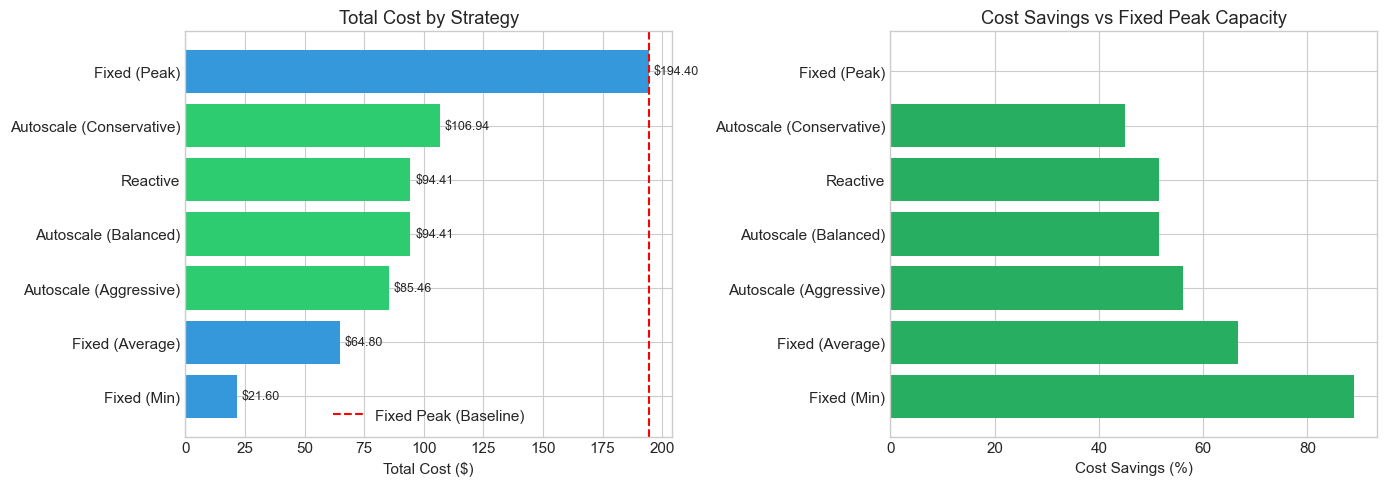

In [8]:
# Visualize cost comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total cost bar chart
ax1 = axes[0]
colors = ['#2ecc71' if 'Autoscale' in s or s == 'Reactive' else '#3498db' for s in comparison_df['Strategy']]
bars = ax1.barh(comparison_df['Strategy'], comparison_df['Total Cost ($)'], color=colors)
ax1.set_xlabel('Total Cost ($)')
ax1.set_title('Total Cost by Strategy')
ax1.axvline(baseline_cost, color='red', linestyle='--', label='Fixed Peak (Baseline)')
ax1.legend()

# Add cost labels
for bar, cost in zip(bars, comparison_df['Total Cost ($)']):
    ax1.text(cost + baseline_cost * 0.01, bar.get_y() + bar.get_height()/2, 
             f'${cost:.2f}', va='center', fontsize=9)

# Savings percentage
ax2 = axes[1]
savings_pct = (baseline_cost - comparison_df['Total Cost ($)']) / baseline_cost * 100
colors2 = ['#27ae60' if s > 0 else '#e74c3c' for s in savings_pct]
ax2.barh(comparison_df['Strategy'], savings_pct, color=colors2)
ax2.set_xlabel('Cost Savings (%)')
ax2.set_title('Cost Savings vs Fixed Peak Capacity')
ax2.axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig('../DATA/processed/cost_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Cost-SLA Tradeoff Analysis

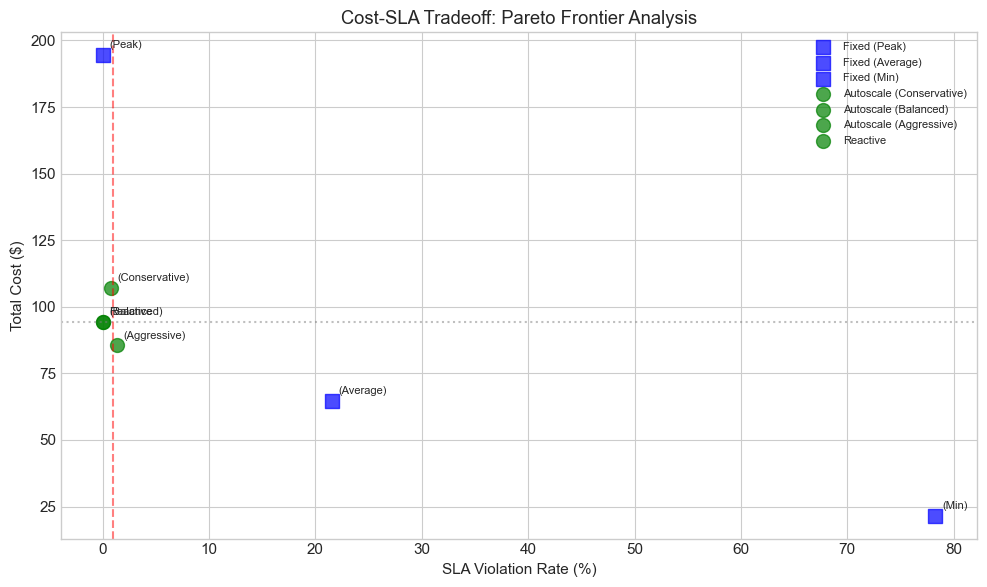

In [9]:
# Plot cost vs SLA violation rate (Pareto frontier)
fig, ax = plt.subplots(figsize=(10, 6))

for name, metrics in results.items():
    marker = 's' if 'Fixed' in name else 'o'
    color = 'blue' if 'Fixed' in name else 'green'
    ax.scatter(metrics.sla_violation_rate * 100, metrics.total_cost, 
               s=100, marker=marker, c=color, label=name, alpha=0.7)
    ax.annotate(name.replace('Autoscale ', '').replace('Fixed ', ''), 
                (metrics.sla_violation_rate * 100, metrics.total_cost),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('SLA Violation Rate (%)')
ax.set_ylabel('Total Cost ($)')
ax.set_title('Cost-SLA Tradeoff: Pareto Frontier Analysis')
ax.legend(loc='upper right', fontsize=8)

# Add quadrant annotations
ax.axhline(comparison_df['Total Cost ($)'].median(), color='gray', linestyle=':', alpha=0.5)
ax.axvline(1.0, color='red', linestyle='--', alpha=0.5, label='1% SLA Target')

plt.tight_layout()
plt.savefig('../DATA/processed/cost_sla_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Identify Pareto-optimal strategies
print("Pareto Analysis:")
print("="*60)

# Sort by cost and check if dominated
pareto_optimal = []
for name, metrics in sorted(results.items(), key=lambda x: x[1].total_cost):
    is_dominated = False
    for other_name, other_metrics in results.items():
        if other_name != name:
            # Check if other dominates this (lower cost AND lower/equal SLA violations)
            if (other_metrics.total_cost <= metrics.total_cost and 
                other_metrics.sla_violation_rate < metrics.sla_violation_rate):
                is_dominated = True
                break
    
    status = "PARETO OPTIMAL" if not is_dominated else "Dominated"
    print(f"{name}: Cost=${metrics.total_cost:.2f}, SLA={metrics.sla_violation_rate:.2%} - {status}")
    
    if not is_dominated:
        pareto_optimal.append(name)

Pareto Analysis:
Fixed (Min): Cost=$21.60, SLA=78.28% - PARETO OPTIMAL
Fixed (Average): Cost=$64.80, SLA=21.53% - PARETO OPTIMAL
Autoscale (Aggressive): Cost=$85.46, SLA=1.31% - PARETO OPTIMAL
Autoscale (Balanced): Cost=$94.41, SLA=0.00% - PARETO OPTIMAL
Reactive: Cost=$94.41, SLA=0.00% - PARETO OPTIMAL
Autoscale (Conservative): Cost=$106.94, SLA=0.77% - Dominated
Fixed (Peak): Cost=$194.40, SLA=0.00% - PARETO OPTIMAL


## 6. Time Series Visualization

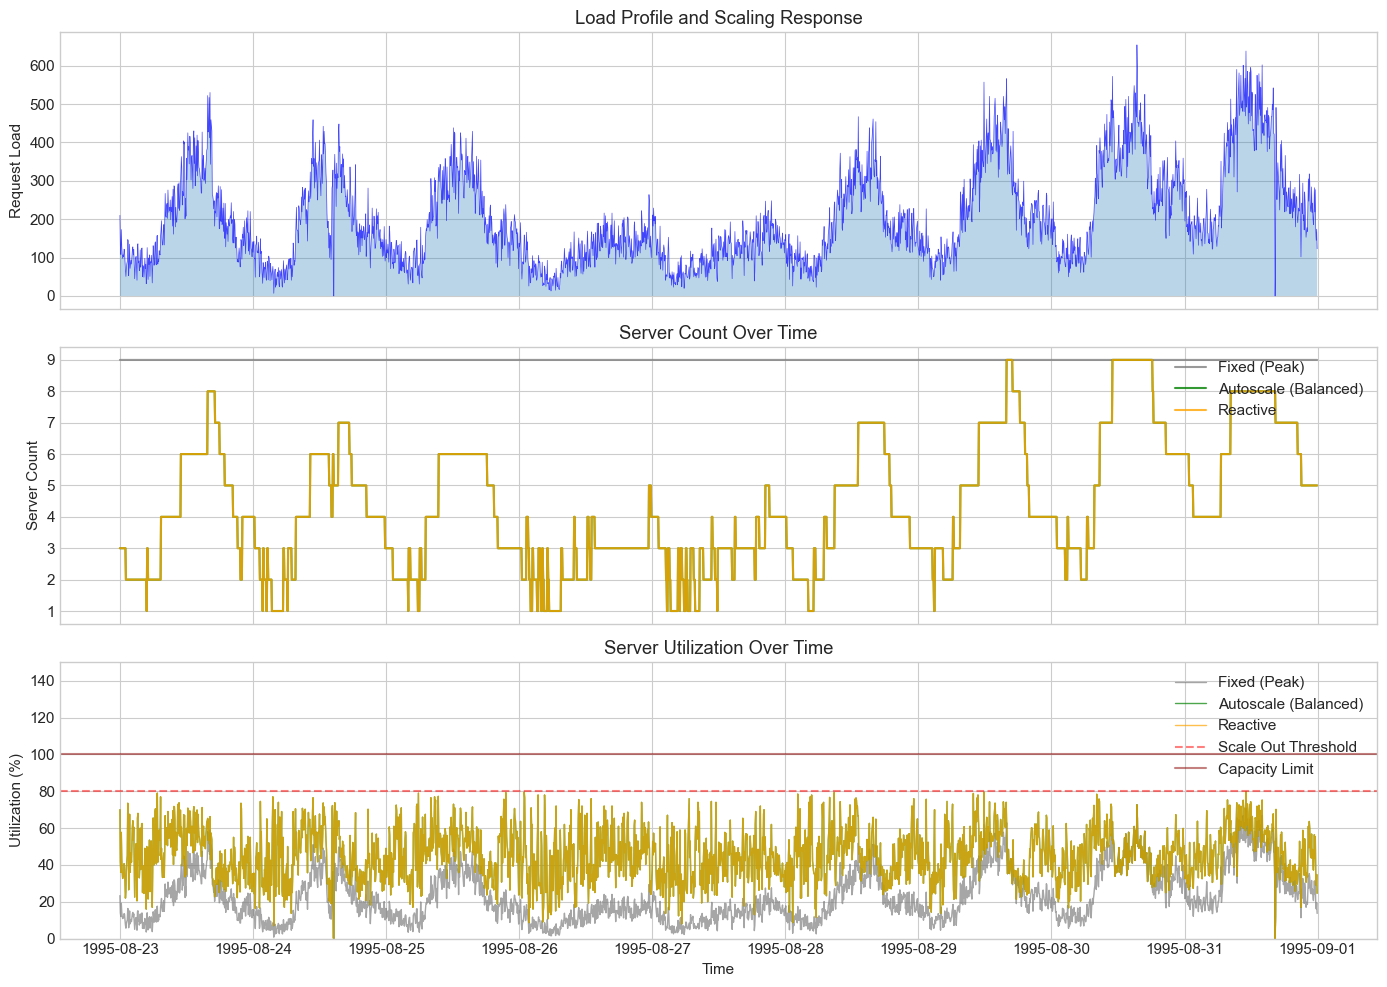

In [11]:
# Compare server count over time for key strategies
strategies_to_plot = ['Fixed (Peak)', 'Autoscale (Balanced)', 'Reactive']

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Load profile
ax1 = axes[0]
ax1.plot(timestamps, loads, color='blue', alpha=0.7, linewidth=0.5)
ax1.fill_between(timestamps, 0, loads, alpha=0.3)
ax1.set_ylabel('Request Load')
ax1.set_title('Load Profile and Scaling Response')

# Server count comparison
ax2 = axes[1]
colors = {'Fixed (Peak)': 'gray', 'Autoscale (Balanced)': 'green', 'Reactive': 'orange'}
for name in strategies_to_plot:
    servers = results[name].servers_over_time
    ax2.plot(timestamps[:len(servers)], servers, label=name, 
             color=colors[name], linewidth=1.5, alpha=0.8)
ax2.set_ylabel('Server Count')
ax2.legend(loc='upper right')
ax2.set_title('Server Count Over Time')

# Utilization comparison
ax3 = axes[2]
for name in strategies_to_plot:
    util = results[name].utilization_over_time
    ax3.plot(timestamps[:len(util)], np.array(util) * 100, label=name,
             color=colors[name], linewidth=1, alpha=0.7)
ax3.axhline(80, color='red', linestyle='--', alpha=0.5, label='Scale Out Threshold')
ax3.axhline(100, color='darkred', linestyle='-', alpha=0.5, label='Capacity Limit')
ax3.set_ylabel('Utilization (%)')
ax3.set_xlabel('Time')
ax3.legend(loc='upper right')
ax3.set_title('Server Utilization Over Time')
ax3.set_ylim(0, 150)

plt.tight_layout()
plt.savefig('../DATA/processed/scaling_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Detailed Cost Breakdown

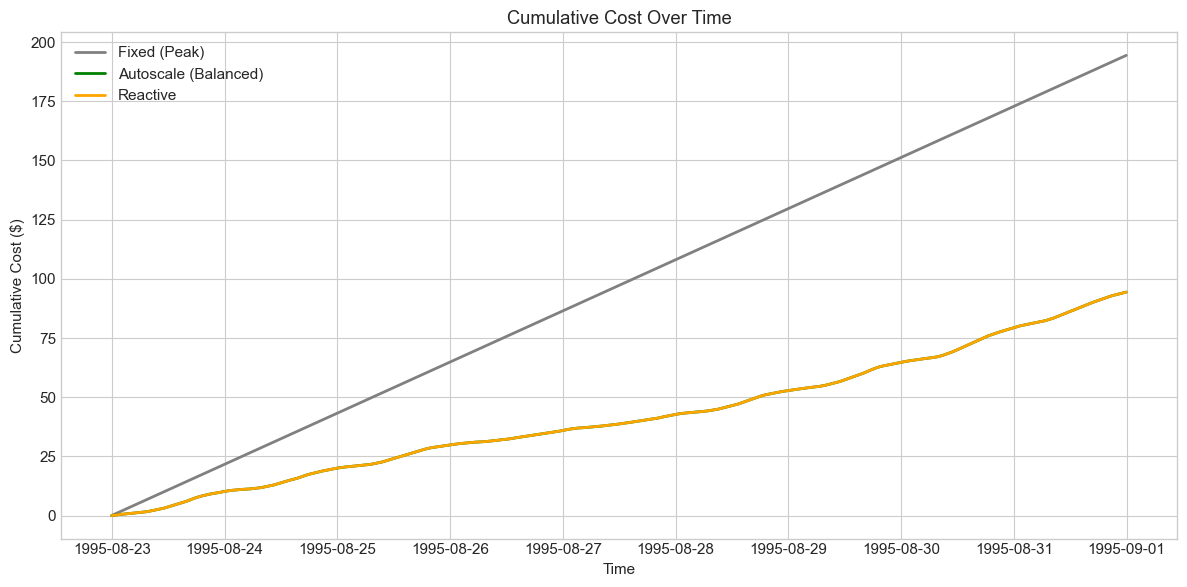

In [12]:
# Cumulative cost over time
fig, ax = plt.subplots(figsize=(12, 6))

for name in strategies_to_plot:
    costs = np.cumsum(results[name].cost_over_time)
    ax.plot(timestamps[:len(costs)], costs, label=name, 
            color=colors[name], linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Cost ($)')
ax.set_title('Cumulative Cost Over Time')
ax.legend()

plt.tight_layout()
plt.savefig('../DATA/processed/cumulative_cost.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Calculate hourly costs
hourly_stats = {}
for name in strategies_to_plot:
    costs = results[name].cost_over_time
    # Group by hour (12 periods of 5 min = 1 hour)
    hourly_costs = [sum(costs[i:i+12]) for i in range(0, len(costs), 12)]
    hourly_stats[name] = {
        'mean': np.mean(hourly_costs),
        'std': np.std(hourly_costs),
        'min': np.min(hourly_costs),
        'max': np.max(hourly_costs),
    }

print("Hourly Cost Statistics:")
print("="*70)
for name, stats in hourly_stats.items():
    print(f"{name}:")
    print(f"  Mean: ${stats['mean']:.4f}/hour")
    print(f"  Std:  ${stats['std']:.4f}")
    print(f"  Range: ${stats['min']:.4f} - ${stats['max']:.4f}")
    print()

Hourly Cost Statistics:
Fixed (Peak):
  Mean: $0.9000/hour
  Std:  $0.0000
  Range: $0.9000 - $0.9000

Autoscale (Balanced):
  Mean: $0.4371/hour
  Std:  $0.2055
  Range: $0.1000 - $0.9000

Reactive:
  Mean: $0.4371/hour
  Std:  $0.2055
  Range: $0.1000 - $0.9000



## 8. SLA Violation Analysis

In [14]:
# Identify when SLA violations occur
balanced_util = np.array(results['Autoscale (Balanced)'].utilization_over_time)
violation_mask = balanced_util > 1.0
violation_times = timestamps[violation_mask]

print(f"SLA Violation Analysis (Balanced Autoscaling):")
print(f"  Total violations: {len(violation_times)}")
print(f"  Violation rate: {len(violation_times) / len(timestamps):.2%}")

if len(violation_times) > 0:
    print(f"\nViolation periods:")
    # Group consecutive violations
    violation_indices = np.where(violation_mask)[0]
    groups = []
    current_group = [violation_indices[0]]
    
    for i in range(1, len(violation_indices)):
        if violation_indices[i] - violation_indices[i-1] == 1:
            current_group.append(violation_indices[i])
        else:
            groups.append(current_group)
            current_group = [violation_indices[i]]
    groups.append(current_group)
    
    print(f"  {len(groups)} distinct overload periods")
    for i, group in enumerate(groups[:5]):  # Show first 5
        start_time = timestamps[group[0]]
        duration = len(group) * 5  # minutes
        max_util = balanced_util[group].max()
        print(f"  Period {i+1}: {start_time}, duration={duration}min, max_util={max_util:.1%}")

SLA Violation Analysis (Balanced Autoscaling):
  Total violations: 0
  Violation rate: 0.00%


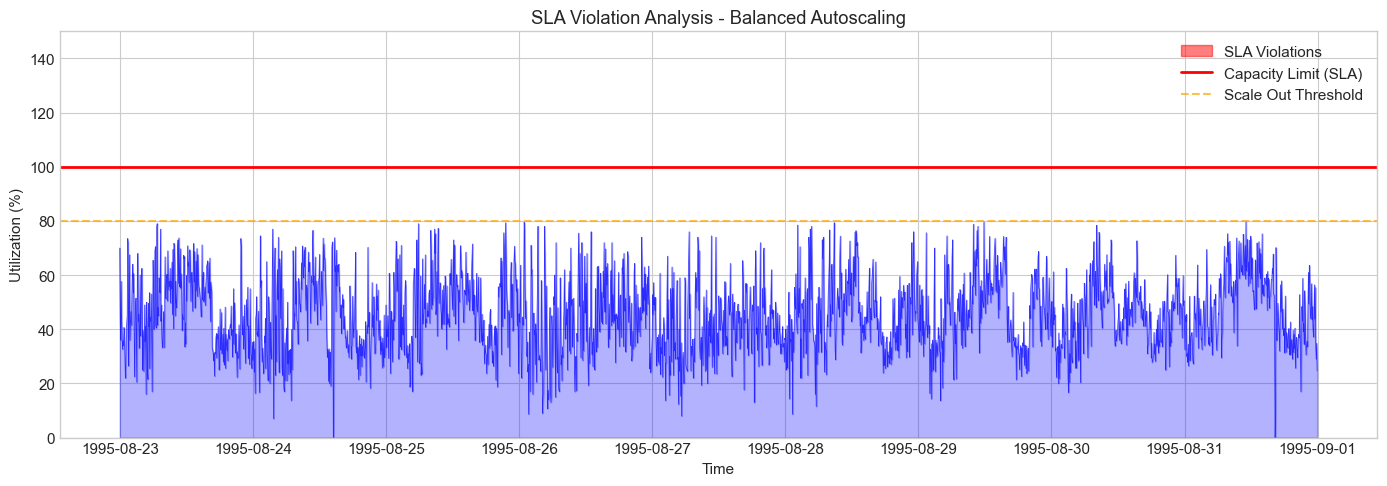

In [15]:
# Visualize SLA violations
fig, ax = plt.subplots(figsize=(14, 5))

ax.fill_between(timestamps, 0, balanced_util * 100, alpha=0.3, color='blue')
ax.plot(timestamps, balanced_util * 100, color='blue', linewidth=0.5, alpha=0.7)

# Highlight violations
violation_util = np.where(balanced_util > 1.0, balanced_util * 100, np.nan)
ax.fill_between(timestamps, 100, violation_util, alpha=0.5, color='red', label='SLA Violations')

ax.axhline(100, color='red', linestyle='-', linewidth=2, label='Capacity Limit (SLA)')
ax.axhline(80, color='orange', linestyle='--', alpha=0.7, label='Scale Out Threshold')

ax.set_xlabel('Time')
ax.set_ylabel('Utilization (%)')
ax.set_title('SLA Violation Analysis - Balanced Autoscaling')
ax.legend(loc='upper right')
ax.set_ylim(0, max(150, balanced_util.max() * 100 + 10))

plt.tight_layout()
plt.savefig('../DATA/processed/sla_violations.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Recommendation Summary

In [16]:
# Final recommendation
print("="*70)
print("COST SIMULATION SUMMARY")
print("="*70)

# Best strategy by different criteria
best_cost = min(results.items(), key=lambda x: x[1].total_cost)
best_sla = min(results.items(), key=lambda x: x[1].sla_violation_rate)
best_balanced = min(
    [(k, v) for k, v in results.items() if v.sla_violation_rate < 0.05],
    key=lambda x: x[1].total_cost,
    default=(None, None)
)

print(f"\nBest by Total Cost: {best_cost[0]}")
print(f"  Cost: ${best_cost[1].total_cost:.2f}")
print(f"  SLA Violations: {best_cost[1].sla_violation_rate:.1%}")

print(f"\nBest by SLA Compliance: {best_sla[0]}")
print(f"  Cost: ${best_sla[1].total_cost:.2f}")
print(f"  SLA Violations: {best_sla[1].sla_violation_rate:.1%}")

if best_balanced[0]:
    print(f"\nBest Balanced (<5% SLA violations, lowest cost): {best_balanced[0]}")
    print(f"  Cost: ${best_balanced[1].total_cost:.2f}")
    print(f"  SLA Violations: {best_balanced[1].sla_violation_rate:.1%}")
    print(f"  Savings vs Fixed Peak: ${baseline_cost - best_balanced[1].total_cost:.2f} ({(baseline_cost - best_balanced[1].total_cost) / baseline_cost * 100:.1f}%)")

print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)
print("""
For production deployment, consider:

1. If SLA is critical (< 1% violations):
   - Use Conservative Autoscaling or Fixed Peak capacity
   - Higher cost but guaranteed reliability

2. If cost optimization is priority (< 5% violations acceptable):
   - Use Balanced Autoscaling
   - Significant cost savings with acceptable SLA

3. For maximum cost savings (higher risk):
   - Use Aggressive Autoscaling
   - May have more SLA violations during traffic spikes

4. For predictable workloads:
   - Consider Predictive scaling with ML forecasts
   - Pre-scale before anticipated traffic spikes
""")

COST SIMULATION SUMMARY

Best by Total Cost: Fixed (Min)
  Cost: $21.60
  SLA Violations: 78.3%

Best by SLA Compliance: Fixed (Peak)
  Cost: $194.40
  SLA Violations: 0.0%

Best Balanced (<5% SLA violations, lowest cost): Autoscale (Aggressive)
  Cost: $85.46
  SLA Violations: 1.3%
  Savings vs Fixed Peak: $108.94 (56.0%)

RECOMMENDATION:

For production deployment, consider:

1. If SLA is critical (< 1% violations):
   - Use Conservative Autoscaling or Fixed Peak capacity
   - Higher cost but guaranteed reliability

2. If cost optimization is priority (< 5% violations acceptable):
   - Use Balanced Autoscaling
   - Significant cost savings with acceptable SLA

3. For maximum cost savings (higher risk):
   - Use Aggressive Autoscaling
   - May have more SLA violations during traffic spikes

4. For predictable workloads:
   - Consider Predictive scaling with ML forecasts
   - Pre-scale before anticipated traffic spikes



In [17]:
# Export results
comparison_df.to_csv('../DATA/processed/scaling_comparison.csv', index=False)
print("Results exported to DATA/processed/scaling_comparison.csv")

Results exported to DATA/processed/scaling_comparison.csv
